# Lesson 6: Essay Writer

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
#memory = SqliteSaver.from_conn_string(":memory:")

In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var]=getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [3]:
# 相比之前，我们的AgentState要复杂一些，我们想跟踪如下信息：
# task, 代表用户输入，要求写一篇关于什么的论文。
# plan, 规划Agent将生成什么。
# draft, 保存生成的论文草稿。
# critique, 对论文草案的改进意见。
# content，保存Tavily搜索到的与plan或critique相关的信息，注意，content的内容是具体的信息，而不是网址链接。
# revision_number，保存已经进行多少次修订。
# max_revisions，保存我们最多允许进行多少次修订。

# plan_node用来生成论文大纲，更新plan键值。
# research_plan_node和research_critique_node通过调用Tavily工具查找论文大纲(plan)或改进意见(critique)相关资料，更新content键值。
# generation_node用来生成论文草稿，更新draft和revision_number这2个键值。
# reflection_node针对论文草稿生成改进意见，更新critique键值。
# 每次graph运行时，会传入用户要求写哪方面的论文，即task，更新task键值。同时也会初始化max_revisions和revision_number键值。

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
#from langchain_openai import ChatOpenAI
#model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(
    model_name='qwen2.5:32b',
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=True
)

论文规划提示词：你是一位专业作家，任务是为一篇论文撰写高级别大纲。根据用户提供的主题，写出这样的大纲。提供论文的大纲以及各部分的相关说明或指示。

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

论文写作提示词：你是一位论文助手，任务是撰写优秀的五段式论文。根据用户的请求和初始大纲，生成尽可能好的论文。如果用户提供批评意见，请回复按意见修订的版本。根据需要利用所有以下信息：{content}

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

论文评价提示词：你是一位老师，负责批改一篇论文提交。请为该论文提供评价和改进建议。你的反馈应包含详细的建议，涉及论文的长度、深度、风格等方面的要求。

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

对论文plan进行研究（通过Tavily搜索）提示词：你是一位研究人员，负责提供可用于撰写以下论文的信息。生成一份搜索查询列表，以供（Tavily）使用，搜索所有相关信息。最多只生成3个查询。

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


对论文改进意见进行研究（通过Tavily搜索）提示词：你是一位研究人员，负责提供可用于进行任何要求的修订（如以下大纲所述）的信息。生成一份搜索查询列表，供（Tavily）使用，以搜索所有相关信息。最多只生成3个查询。

In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


research plan或者research critique（通过LLM）将生成要搜索的内容的列表，传递给Tavily进行搜索，为此，我们将使用function call，确保我们从LLM得到一个搜索列表。所以，我们使用Pydantic定义Queries类，确保我们从LLM得到的回复是字符串列表，好搜索列表。

In [10]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

现在，我们开始创建所有不同的node，每个node也可以称为是一个Agent。  

首先是plan node（或plan Agent）：

In [12]:
# plan node（或plan Agent）要做的是接收state，创建一个消息列表。其中SystemMessage是plan prompt，HumanMessage是task，即要写关于哪方面的论文。
# 将消息列表传递给LLM，得到的response.content将作为plan返回。注意，这将会更新state的"plan"键值。
def plan_node(state: AgentState):
    # 创建一个消息列表，SystemMessage是PLAN_PROMPT，HumanMessage是"task"，即要生成关于哪方面的论文。
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]

    # 将消息列表传递给LLM，返回的response.content即LLM生成的论文写作plan。
    response = model.invoke(messages)

    # 更新state “plan"键值。
    return {"plan": response.content}

In [13]:
# research plan node（或Agent）接收state，通过给model传递RESEARCH_PLAN_PROMPT和task，生成queries。
# 然后取得当前state的content，即参考内容。
# 然后对于每一个query，调用Tavily工具搜索，将搜索得到的参考内容追加到content中。
# 最后返回content，即参考文档列表。注意，这将更新state的"content"键值。
def research_plan_node(state: AgentState):

    # 创建包含RESEARCH_PLAN_PROMPT和"task"的消息列表，传递给LLM，LLM生成针对task的搜索queries。
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])

    # 取得当前已有的state "content"，赋值给content
    #content = state['content'] or []
    content = state.get('content', []) or []

    # 针对每一个query，使用Tavily进行搜索，得到的内容追加到content中。
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])

    # 更新state "content"键值。
    return {"content": content}

前面我们制定了一个plan，进行了一些research，现在可以写第一稿了：

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])  # 将所有state['content']连接在一起（注意，'content'是具体内容，而不是网址链接），保存在content变量中。

    # 创建用户输入，包括了"task"（要写关于哪方面的论文） 和"plan"（论文写作大纲），
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")

    # 创建消息列表messages，其中SystemMessage是WRITER_PROMPT（包括research_plan_node通过Tavily搜索得到的相关资料）。
    # HumanMessage就是上面创建的user_message，包括"task"和"plan"。
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    
    # 将消息列表传递给LLM，得到的response.content就是LLM根据messages中的消息生成的论文草稿
    response = model.invoke(messages)

    # 更新state的"draft"和"revision_number"键值。
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


生成了论文草稿之后，我们需要对论文进行反思，生成对论文草稿的改进意见：

In [15]:
# reflection node对论文草稿进行反思，提出改进意见
def reflection_node(state: AgentState):
    # 创建消息列表，SystemMessage是反思提示词，HumanMessage是论文草稿。
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]

    # 将消息列表传递给LLM，得到的response.content即LLM对论文草稿的改进意见。
    response = model.invoke(messages)

    # 更新state的"critique"键值。
    return {"critique": response.content}

In [16]:
# research critique节点（或Agent）用于对改进意见进行研究，所以它和research plan node做的事情很类似。
def research_critique_node(state: AgentState):

    # 将改进意见和对应的RESEARCH_CRITIQUE_PROMPT传递给LLM，得到要做哪些queries。
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])

    # 取得当前state['content']，赋值给content变量
    # content = state['content'] or []
    content = state.get('content', []) or []

    # 针对每一条query，调用Tavily工具查询，查询结果追加到content中。
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])

    # 更新state "content"键值。
    return {"content": content}

我们还需要一个判断是否继续改进的函数should_continue。这个函数在generation_node后执行，所以generation_node后，要么END，表示得到论文终稿，要么继续对草稿提出改进意见，再按改进意见查询修改。

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

我们定义了所有需要的node（或称Agent）以及条件，现在我们可以把它们组合成graph了：

In [18]:
# 创建graph
builder = StateGraph(AgentState)

In [19]:
# 添加节点（或者说添加Agent，每个节点都是一个Agent，用于完成自己的功能）
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
# 指定入口节点
builder.set_entry_point("planner")

In [21]:
# 添加条件边，生成论文草稿后，是继续修改还是作为终稿结束。
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
# 添加普通边
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
# 编译graph，编译完成后graph就是一个runnable，支持invoke, stream, batch等接口。
graph = builder.compile(checkpointer=memory)

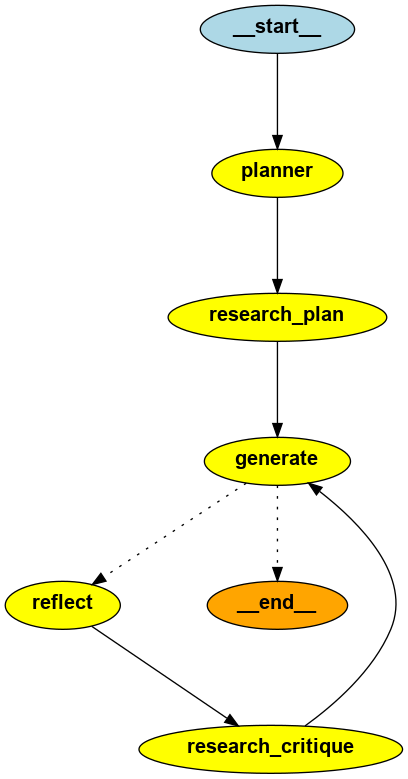

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
# 执行graph，传入task，同时指定max_revisions和revision_number。
# 从打印的信息可以看出，因为设置max_revisions为2，所以graph的执行经历了如下过程：
# 'planner'-->'research_plan'-->'generate'-->'reflect'-->'research_critique'-->'generate'

thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    #'task': "what is the difference between langchain and langsmith",
    'task': "怎样进行基于qwen2.5大模型的Agent开发？",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)
    print("--------------------------------------------------------------")

{'planner': {'plan': '题目：如何根据Qwen2.5大型语言模型进行Agent开发\n\n**I. 引言**\n   - A. 介绍Qwen2.5模型的核心特点和优势。\n   - B. 概述Agent的概念及其在智能系统中的应用。\n   - C. 提出研究的目的与意义：探讨基于Qwen2.5的Agent开发框架。\n\n**II. Qwen2.5综述**\n   - A. 技术背景说明：描述Qwen2.5大模型的基础构成和工作机制。\n   - B. 能力概述：总结该模型在自然语言处理上的高级能力和适用范围，如文本生成、语义理解等。\n\n**III. Agent设计原则与方法论**\n   - A. 定义目标用户群体及应用场景。\n   - B. 设计Agent架构的基本框架和组成部分（感知模块、决策模块、执行模块）。\n   - C. 讨论选择Qwen2.5作为核心引擎的原因及其在各模块中的应用方式。\n\n**IV. Agent开发流程**\n   - A. 需求分析：明确用户需求，定义Agent所要承担的任务和角色。\n   - B. 设计与实现：\n      1. 利用Qwen2.5的API进行编程接口绑定\n      2. 模型微调和定制化开发以优化特定功能或性能\n      3. 编写逻辑代码处理Agent工作流程。\n   - C. 测试与验证：通过多种情境下的测试来确保Agent的行为符合预期并与Qwen2.5的输出保持一致。\n\n**V. 应用示例**\n   - A. 创造一个具体的使用场景作为示例说明，比如虚拟助手或者对话系统。\n   - B. 描述在这个案例中如何将Qwen2.5的功能优势发挥到极致，并详细列出技术细节和实现步骤。\n\n**VI. 挑战和未来方向**\n   - A. 讨论在基于Qwen2.5的Agent开发过程中可能遇到的问题，如数据隐私、模型偏倚和技术成熟度等。\n   - B. 探讨改进方法与技术展望，即为解决现有问题以及进一步优化或扩展功能而提出可能的技术创新方向。\n\n**VII. 结论**\n   - A. 重申本文的主要观点和贡献\n   - B. 强调Qwen2.5在Agent开发中的潜力及未来应用前景\n\n注：每个部分都应围绕如何利用Qwen2.5的能力来增强或创建A

/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_plan': {'content': ['文章浏览阅读3.3k次，点赞15次，收藏8次。通过本教程，你已经学会了如何本地部署 Qwen-2.5 模型，并构建一个智能 Agent。如果你在实际操作中遇到问题，欢迎留言与我们互动!😊。_qwen2.5-vl本地部署', 'Qwen-Agent：基于Qwen 2.5模型的智能Agent构建与应用-阿里云开发者社区 开发者社区 人工智能 文章 正文 Qwen-Agent：基于Qwen 2.5模型的智能Agent构建与应用 简介： Qwen-Agent：基于Qwen 2.5模型的智能Agent构建与应用 Qwen-Agent的主要特点： • 任务驱动的自动化：Qwen 2.5可以基于用户输入的需求自动执行任务，如查询信息、调度资源等。 • 上下文理解与多轮对话：Qwen 2.5能够理解用户的上下文语境，进行多轮对话，并保持连续性与一致性。 • 跨领域应用能力：无论是客户服务、知识管理、智能助手，Qwen 2.5都能支持不同领域的智能Agent应用。 Qwen 2.5模型具备强大的生成能力和深度理解能力，可以在多个智能Agent应用场景中提供高效支持。常见的应用场景包括： • 智能客服与客户支持：Qwen 2.5可以帮助企业构建自动化客服系统，解决客户问题，提供信息查询、反馈收集等功能。 • 个人助手与任务管理：Qwen 2.5能够充当个人智能助手，管理日程、提醒任务、解答问题等。 • 多轮对话与问题解决：Qwen 2.5能够进行多轮对话，追踪任务进度，并根据需求生成相应的操作指令。 from qwen import QwenModel, QwenTokenizer model = QwenModel.from_pretrained("qwen-2.5-agent") tokenizer = QwenTokenizer.from_pretrained("qwen-2.5-agent") input_text = "如何申请退款?" 使用Qwen 2.5生成回应 inputs = tokenizer(input_text, return_tensors="pt") outputs = model.generate(inputs["input_ids"], max_length=100) generated_r

/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_critique': {'content': ['文章浏览阅读3.3k次，点赞15次，收藏8次。通过本教程，你已经学会了如何本地部署 Qwen-2.5 模型，并构建一个智能 Agent。如果你在实际操作中遇到问题，欢迎留言与我们互动!😊。_qwen2.5-vl本地部署', 'Qwen-Agent：基于Qwen 2.5模型的智能Agent构建与应用-阿里云开发者社区 开发者社区 人工智能 文章 正文 Qwen-Agent：基于Qwen 2.5模型的智能Agent构建与应用 简介： Qwen-Agent：基于Qwen 2.5模型的智能Agent构建与应用 Qwen-Agent的主要特点： • 任务驱动的自动化：Qwen 2.5可以基于用户输入的需求自动执行任务，如查询信息、调度资源等。 • 上下文理解与多轮对话：Qwen 2.5能够理解用户的上下文语境，进行多轮对话，并保持连续性与一致性。 • 跨领域应用能力：无论是客户服务、知识管理、智能助手，Qwen 2.5都能支持不同领域的智能Agent应用。 Qwen 2.5模型具备强大的生成能力和深度理解能力，可以在多个智能Agent应用场景中提供高效支持。常见的应用场景包括： • 智能客服与客户支持：Qwen 2.5可以帮助企业构建自动化客服系统，解决客户问题，提供信息查询、反馈收集等功能。 • 个人助手与任务管理：Qwen 2.5能够充当个人智能助手，管理日程、提醒任务、解答问题等。 • 多轮对话与问题解决：Qwen 2.5能够进行多轮对话，追踪任务进度，并根据需求生成相应的操作指令。 from qwen import QwenModel, QwenTokenizer model = QwenModel.from_pretrained("qwen-2.5-agent") tokenizer = QwenTokenizer.from_pretrained("qwen-2.5-agent") input_text = "如何申请退款?" 使用Qwen 2.5生成回应 inputs = tokenizer(input_text, return_tensors="pt") outputs = model.generate(inputs["input_ids"], max_length=100) generat

## Essay Writer Interface

In [26]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [27]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
